In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn. cross_decomposition import PLSRegression
from ISLP.models import (Stepwise , sklearn_selected , sklearn_selection_path )

In [3]:
from l0bnb import fit_path

## 6.5.1 Subset Selection Methods

### Forward Selection

In [4]:
Hitters = load_data('Hitters')
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [5]:
Hitters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   AtBat      322 non-null    int64   
 1   Hits       322 non-null    int64   
 2   HmRun      322 non-null    int64   
 3   Runs       322 non-null    int64   
 4   RBI        322 non-null    int64   
 5   Walks      322 non-null    int64   
 6   Years      322 non-null    int64   
 7   CAtBat     322 non-null    int64   
 8   CHits      322 non-null    int64   
 9   CHmRun     322 non-null    int64   
 10  CRuns      322 non-null    int64   
 11  CRBI       322 non-null    int64   
 12  CWalks     322 non-null    int64   
 13  League     322 non-null    category
 14  Division   322 non-null    category
 15  PutOuts    322 non-null    int64   
 16  Assists    322 non-null    int64   
 17  Errors     322 non-null    int64   
 18  Salary     263 non-null    float64 
 19  NewLeague  322 non-null    ca

In [6]:
Hitters.isna().sum()

AtBat         0
Hits          0
HmRun         0
Runs          0
RBI           0
Walks         0
Years         0
CAtBat        0
CHits         0
CHmRun        0
CRuns         0
CRBI          0
CWalks        0
League        0
Division      0
PutOuts       0
Assists       0
Errors        0
Salary       59
NewLeague     0
dtype: int64

In [7]:
np.isnan(Hitters['Salary']).sum()

59

In [8]:
Hitters.shape

(322, 20)

In [9]:
Hitters = Hitters.dropna()
Hitters.shape

(263, 20)

In [10]:
def nCp(sigma2 , estimator , X, Y):
    "Negative Cp statistic"
    n, p = X.shape              # n = samples, p = features
    Yhat = estimator.predict(X) # Get predictions
    RSS = np.sum((Y - Yhat)**2) # Calculate residual sum of squares
    return -(RSS + 2 * p * sigma2) / n  # Return negative Cp

In [11]:
# Create a ModelSpec object using all columns except the target variable 'Salary '
# This defines how to transform the predictors (handles categorical encoding, etc.)
design = MS(Hitters.columns.drop('Salary')).fit(Hitters)

# Extract the target variable (what we want to predict) as a numpy array
Y = np.array(Hitters['Salary'])

# Transform the raw data into a proper design matrix using the fitted ModelSpec
# This applies one-hot encoding, adds intercept, and formats data for regression
X = design.transform(Hitters)

# Estimate the error variance (sigma²) from the full model with all predictors
# This sigma² will be used in the Cp statistic for model selection
# OLS fits ordinary least squares, .scale extracts the residual variance estimate
sigma2 = OLS(Y,X).fit().scale

In [12]:
# "Freeze" the first argument (sigma2) to create a 3-parameter function
neg_Cp = partial(nCp, sigma2)

In [13]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms))

In [14]:
strategy

Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7f4088cc6c90>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=<function first_peak at 0x7f40908e0220>, postprocess=<function _postprocess_best at 0x7f40908e04a0>)

In [15]:
hitters_MSE = sklearn_selected(OLS , strategy)
hitters_MSE.fit(Hitters , Y)
hitters_MSE.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Errors',
 'Hits',
 'HmRun',
 'League',
 'NewLeague',
 'PutOuts',
 'RBI',
 'Runs',
 'Walks',
 'Years')

In [16]:
hitters_MSE

sklearn_selected(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                 strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7f4088cc6c90>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=<function first_peak at 0x7f40908e0220>, postprocess=<function _postprocess_best at 0x7f40908e04a0>))

In [17]:
len(hitters_MSE.selected_state_)

19

In [18]:
hitters_Cp = sklearn_selected(OLS , strategy , scoring=neg_Cp)
hitters_Cp.fit(Hitters , Y)
hitters_Cp.selected_state_

('Assists',
 'AtBat',
 'CAtBat',
 'CRBI',
 'CRuns',
 'CWalks',
 'Division',
 'Hits',
 'PutOuts',
 'Walks')

In [19]:
len(hitters_Cp.selected_state_)

10

## Choosing Among Models Using the Validation Set Approach and Cross-Validation

In [20]:
strategy = Stepwise.fixed_steps(design , len(design.terms), direction='forward')
full_path = sklearn_selection_path(OLS , strategy)

In [21]:
full_path

sklearn_selection_path(model_type=<class 'statsmodels.regression.linear_model.OLS'>,
                       strategy=Strategy(initial_state=(), candidate_states=<bound method Stepwise.candidate_states of <ISLP.models.strategy.Stepwise object at 0x7f4088cc7320>>, build_submodel=<bound method ModelSpec.build_submodel of ModelSpec(terms=Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'League', 'Division',
       'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object'))>, check_finished=functools.partial(<function fixed_steps at 0x7f40908e02c0>, 19), postprocess=functools.partial(<function _postprocess_fixed_steps at 0x7f40908e0400>, 19)))

In [22]:
full_path.fit(Hitters , Y)
Yhat_in = full_path.predict(Hitters)
Yhat_in.shape

(263, 20)

In [23]:
df = pd.DataFrame(Yhat_in)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,535.925882,602.035165,505.030861,611.119758,545.817486,564.116846,573.370507,559.747200,475.158790,392.451307,365.069609,376.255883,389.032759,379.024508,378.344140,371.537008,374.063138,372.190294,361.435031,362.136066
1,535.925882,484.974036,564.667133,715.340872,643.856340,649.717402,746.732067,755.986211,728.043326,724.839804,726.044931,702.097371,714.783312,697.458147,701.520602,704.299533,704.260775,706.174062,712.138097,712.695206
2,535.925882,937.399479,995.598882,950.553225,1017.241441,1029.999170,965.434249,1028.441296,1107.969617,1139.687704,1127.226373,1158.051511,1168.927756,1177.237541,1184.555125,1167.355486,1168.694402,1166.412900,1171.290483,1171.311111
3,535.925882,310.964251,270.952948,424.102110,498.247024,525.258684,506.553053,509.655680,507.005949,519.199027,516.460145,534.335536,540.586262,550.960818,556.380957,554.066951,555.020286,552.942507,556.637827,556.787508
4,535.925882,540.340786,741.693029,708.864932,632.383853,638.384174,563.767533,549.152849,620.459881,537.330944,567.387522,542.984799,540.161474,520.007248,509.065783,491.274351,491.807440,493.112956,492.301536,493.251495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,535.925882,520.566947,585.810072,585.805466,654.670265,601.733545,551.272619,569.865311,624.379824,628.166236,584.386267,611.645379,613.359355,624.491659,607.298805,613.476107,615.462784,616.054201,620.741881,622.944507
259,535.925882,631.300447,712.103590,703.310689,770.919503,766.375044,926.671689,818.232982,904.364623,898.509048,948.629149,925.436599,937.902869,919.031480,920.586263,916.947305,909.254268,910.060499,910.099771,914.316712
260,535.925882,348.139069,432.111158,355.419193,284.644696,262.811374,300.992070,290.560954,320.244433,298.802648,270.090054,252.063840,265.100245,266.974154,252.204465,248.524677,244.254741,247.093658,245.712688,243.690976
261,535.925882,606.780886,717.123465,978.437882,1044.964457,976.598543,1021.627182,1033.460908,1087.872291,1082.188489,1089.506248,1063.574117,1058.170032,1055.795734,1029.646863,1023.173168,1023.336191,1026.130088,1023.923402,1023.300298


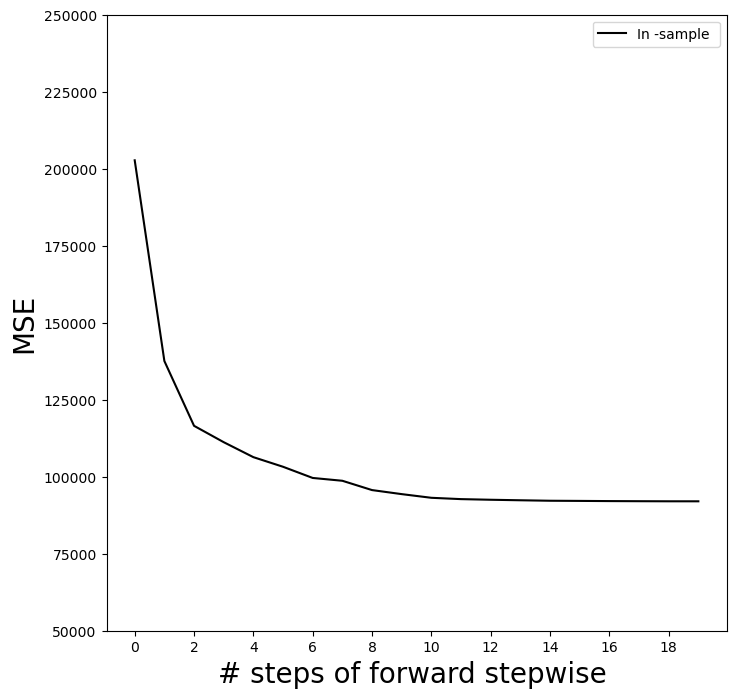

In [46]:
mse_fig , ax = subplots(figsize =(8 ,8))
insample_mse = (( Yhat_in - Y[:,None ]) **2).mean(0)
n_steps = insample_mse.shape[0]

ax.plot(np.arange(n_steps), insample_mse ,
'k', # color black
label='In -sample ')

ax.set_ylabel('MSE', fontsize =20)
ax.set_xlabel('# steps of forward stepwise ',fontsize =20)
ax.set_xticks(np.arange(n_steps)[::2])
ax.legend()
ax.set_ylim([50000 ,250000]);

In [44]:
insample_mse.shape

(20,)

In [ ]:
K = 5
kfold = skm.KFold(K, random_state =0, shuffle=True)
Yhat_cv = skm.cross_val_predict(full_path , Hitters , Y, cv=kfold)
Yhat_cv.shape

(263, 20)

In [49]:
Yhat_cv

array([[ 522.28257619,  590.72713282,  410.32085677, ...,  229.87272728,
         228.96840426,  230.73249093],
       [ 560.05848341,  498.60037086,  580.39175077, ...,  742.78970371,
         742.72895901,  742.76525463],
       [ 522.28257619,  930.03470602,  953.97632714, ..., 1156.30920012,
        1149.50956216, 1168.61363627],
       ...,
       [ 522.28257619,  333.84569179,  390.12799023, ...,  207.33232712,
         203.59324152,  200.14397398],
       [ 560.05848341,  619.1060376 ,  733.04854491, ..., 1047.81920062,
        1048.59251652, 1048.61193527],
       [ 522.28257619,  545.11267133,  673.81963678, ...,  609.5978068 ,
         610.99792911,  624.84722454]])

In [26]:
cv_mse = []
for train_idx , test_idx in kfold.split(Y):
    errors = (Yhat_cv[test_idx] - Y[test_idx ,None ])**2
    cv_mse.append(errors.mean (0)) # column means
cv_mse = np.array(cv_mse).T
cv_mse.shape

(20, 5)

In [51]:
df = pd.DataFrame(cv_mse)
df

,0,1,2,3,4
0,297431.063755,213373.266849,164217.866146,173485.728361,172188.609540
1,179409.947917,171503.221424,119051.868181,116989.192908,140209.859349
2,169081.871366,149740.514395,106610.807553,102201.602307,140916.430736
3,161065.230031,158039.080949,109849.163908,109662.669828,148364.794593
4,143343.947105,136954.505694,97833.920059,101684.741479,145424.241820
5,136980.487880,126681.574432,109241.855467,97215.028674,147981.910277
6,133308.922007,132669.476245,102674.202357,90697.781624,140394.699893
7,131281.920268,172481.813129,95998.897181,95674.582641,137972.873429
8,123424.154869,177296.935387,99621.936216,105832.320362,134588.014601
9,122703.809879,170634.119283,104603.251228,98589.489172,133043.749329


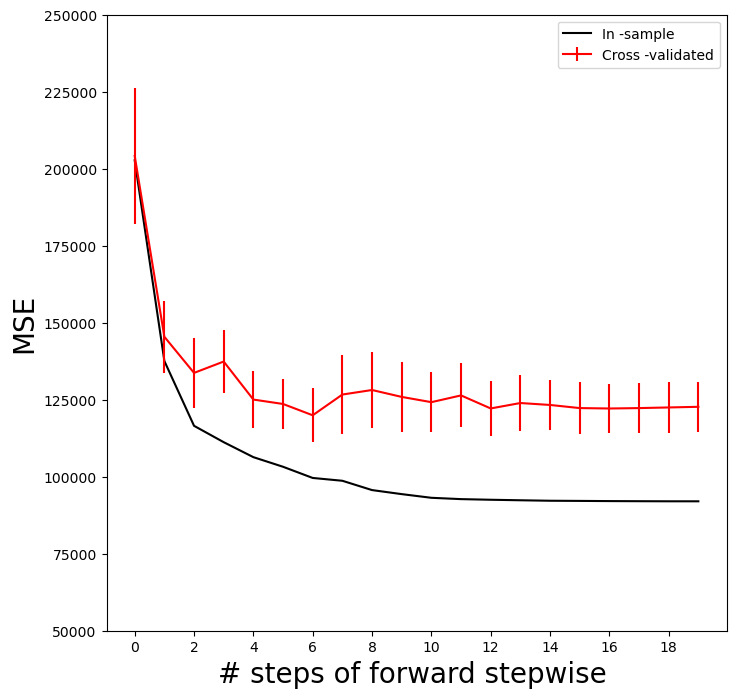

In [27]:
ax.errorbar(np.arange(n_steps), cv_mse.mean(1), cv_mse.std(1) / np.sqrt(K), label='Cross -validated', c='r') # color red
ax.set_ylim ([50000 ,250000])
ax.legend ()
mse_fig

In [28]:
validation = skm.ShuffleSplit(n_splits =1, test_size =0.2, random_state =0)

for train_idx , test_idx in validation.split(Y):
    full_path.fit(Hitters.iloc[train_idx], Y[train_idx ])
    Yhat_val = full_path.predict(Hitters.iloc[test_idx ])
    errors = (Yhat_val - Y[test_idx ,None ])**2
    validation_mse = errors.mean (0)

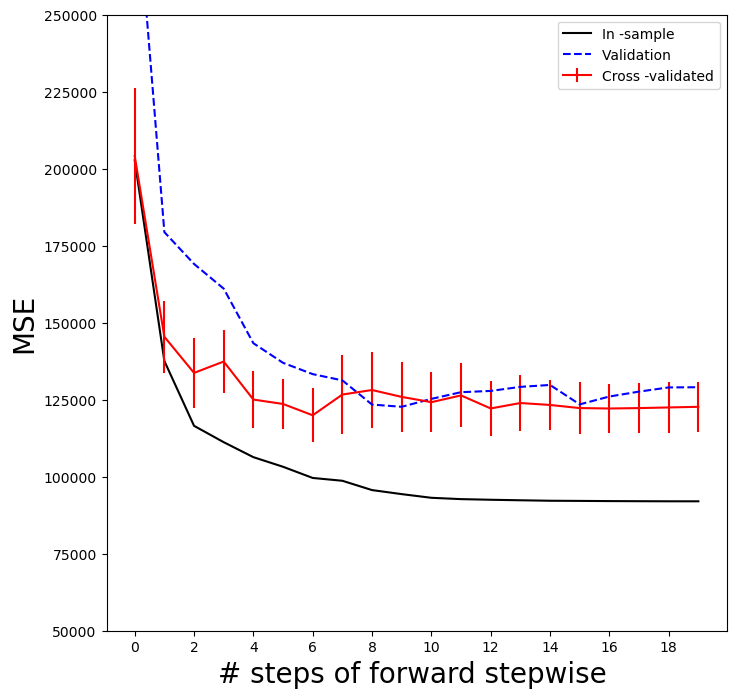

In [29]:
ax.plot(np.arange(n_steps), validation_mse , 'b--', # color blue , broken line
label='Validation ')

ax.set_xticks(np.arange(n_steps)[::2])
ax.set_ylim ([50000 ,250000])
ax.legend()
mse_fig

### Best Subset Selection

In [30]:
D = design.fit_transform(Hitters)
D = D.drop('intercept', axis =1)
X = np.asarray(D)

In [ ]:
D.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,1.0,1.0,632,43,10,1.0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,0.0,1.0,880,82,14,0.0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,1.0,0.0,200,11,3,1.0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,1.0,0.0,805,40,4,1.0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,0.0,1.0,282,421,25,0.0


In [53]:
X

array([[315.,  81.,   7., ...,  43.,  10.,   1.],
       [479., 130.,  18., ...,  82.,  14.,   0.],
       [496., 141.,  20., ...,  11.,   3.,   1.],
       ...,
       [475., 126.,   3., ..., 113.,   7.,   0.],
       [573., 144.,   9., ..., 131.,  12.,   0.],
       [631., 170.,   9., ...,   4.,   3.,   0.]])

In [31]:
path = fit_path(X, Y, max_nonzeros=X.shape [1])

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  2
Iteration: 4. Number of non-zeros:  2
Iteration: 5. Number of non-zeros:  3
Iteration: 6. Number of non-zeros:  3
Iteration: 7. Number of non-zeros:  4
Iteration: 8. Number of non-zeros:  9
Iteration: 9. Number of non-zeros:  9
Iteration: 10. Number of non-zeros:  9
Iteration: 11. Number of non-zeros:  9
Iteration: 12. Number of non-zeros:  9
Iteration: 13. Number of non-zeros:  9
Iteration: 14. Number of non-zeros:  9
Iteration: 15. Number of non-zeros:  9
Iteration: 16. Number of non-zeros:  9
Iteration: 17. Number of non-zeros:  9
Iteration: 18. Number of non-zeros:  17
Iteration: 19. Number of non-zeros:  19


In [32]:
path[3]

{'B': array([0.        , 3.25484367, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.67775265, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ]),
 'B0': -38.98216739555494,
 'lambda_0': 0.011416248027450194,
 'M': 0.5829861733382014,
 'Time_exceeded': False}

## 6.5.2 Ridge Regression and the Lasso

### Ridge Regression

In [ ]:
Xs = X - X.mean(0)[None ,:]
X_scale = X.std(0)
Xs = Xs / X_scale[None ,:]

lambdas = 10** np.linspace(8, -2, 100) / Y.std()
soln_array = skl.ElasticNet.path(Xs , Y, l1_ratio =0., alphas=lambdas)[1]
soln_array.shape

/home/musty/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/musty/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 64428165.36474803, tolerance: 12885.7065737425
  model = cd_fast.enet_coordinate_descent_gram(
/home/musty/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:683: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
/home/musty/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent

(19, 100)

In [34]:
soln_path = pd.DataFrame(soln_array.T, columns=D.columns , index=-np.log(lambdas))
soln_path.index.name = 'negative log(lambda)'
soln_path

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League[N],Division[W],PutOuts,Assists,Errors,NewLeague[N]
negative log(lambda),,,,,,,,,,,,,,,,,,,
-12.310855,0.000800,0.000889,0.000695,0.000851,0.000911,0.000900,0.000812,0.001067,0.001113,0.001064,0.001141,0.001149,0.000993,-0.000029,-0.000390,0.000609,0.000052,-0.000011,-0.000006
-12.078271,0.001010,0.001122,0.000878,0.001074,0.001150,0.001135,0.001025,0.001346,0.001404,0.001343,0.001439,0.001450,0.001253,-0.000037,-0.000492,0.000769,0.000065,-0.000014,-0.000007
-11.845686,0.001274,0.001416,0.001107,0.001355,0.001451,0.001433,0.001293,0.001698,0.001772,0.001694,0.001816,0.001830,0.001581,-0.000046,-0.000621,0.000970,0.000082,-0.000017,-0.000009
-11.613102,0.001608,0.001787,0.001397,0.001710,0.001831,0.001808,0.001632,0.002143,0.002236,0.002138,0.002292,0.002309,0.001995,-0.000058,-0.000784,0.001224,0.000104,-0.000022,-0.000012
-11.380518,0.002029,0.002255,0.001763,0.002158,0.002310,0.002281,0.002059,0.002704,0.002821,0.002698,0.002892,0.002914,0.002517,-0.000073,-0.000990,0.001544,0.000131,-0.000028,-0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9.784658,-290.823989,336.929968,37.322686,-59.748520,-26.507086,134.855915,-17.216195,-387.775826,89.573601,-12.273926,476.079273,257.271255,-213.124780,31.258215,-58.457857,78.761266,53.622113,-22.208456,-12.402891
10.017243,-290.879272,337.113713,37.431373,-59.916820,-26.606957,134.900549,-17.108041,-388.458404,89.000707,-12.661459,477.031349,257.966790,-213.280891,31.256434,-58.448850,78.761240,53.645147,-22.198802,-12.391969
10.249827,-290.923382,337.260446,37.518064,-60.051166,-26.686604,134.936136,-17.022194,-388.997470,88.537380,-12.971603,477.791860,258.523025,-213.405740,31.254958,-58.441682,78.761230,53.663357,-22.191071,-12.383205


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_19270/2445942788.py:3: SyntaxWarning: invalid escape sequence '\l'
  ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)


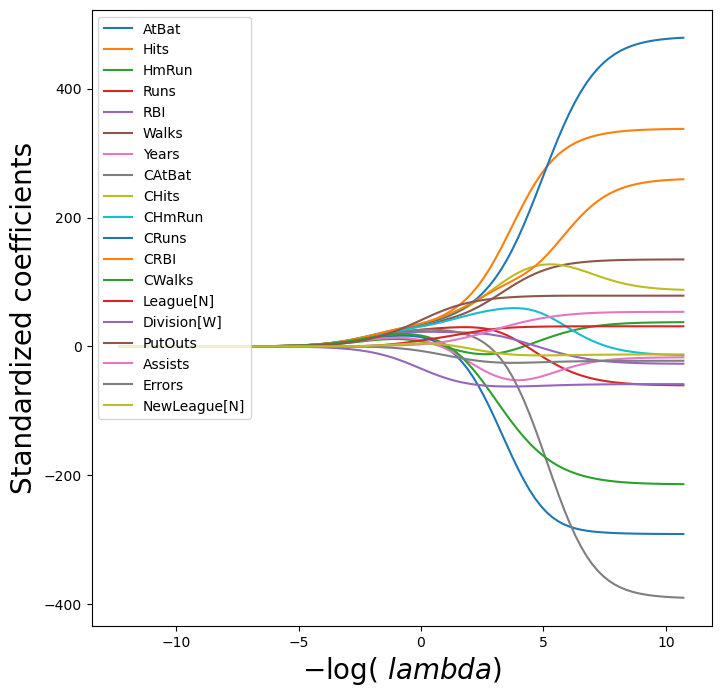

In [35]:
path_fig , ax = subplots(figsize =(8 ,8))
soln_path.plot(ax=ax , legend=False)
ax.set_xlabel('$-\log(\ lambda)$', fontsize =20)
ax.set_ylabel('Standardized coefficients', fontsize =20)
ax.legend(loc='upper left')

In [36]:
beta_hat = soln_path.loc[soln_path.index [39]]
lambdas [39], beta_hat

(25.53538897200662,
 AtBat           5.433750
 Hits            6.223582
 HmRun           4.585498
 Runs            5.880855
 RBI             6.195921
 Walks           6.277975
 Years           5.299767
 CAtBat          7.147501
 CHits           7.539495
 CHmRun          7.182344
 CRuns           7.728649
 CRBI            7.790702
 CWalks          6.592901
 League[N]       0.042445
 Division[W]    -3.107159
 PutOuts         4.605263
 Assists         0.378371
 Errors         -0.135196
 NewLeague[N]    0.150323
 Name: -3.240065292879872, dtype: float64)

In [37]:
np.linalg.norm(beta_hat)

24.17061720144378

In [38]:
beta_hat = soln_path.loc[soln_path.index [59]]
lambdas [59], np.linalg.norm(beta_hat)

(0.24374766133488554, 160.42371017725924)

In [39]:
ridge = skl.ElasticNet(alpha=lambdas [59], l1_ratio =0)
scaler = StandardScaler(with_mean=True , with_std=True)
pipe = Pipeline(steps =[('scaler ', scaler), ('ridge ', ridge)])
pipe.fit(X, Y)

/home/musty/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.446e+07, tolerance: 5.332e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('scaler ', StandardScaler()),
                ('ridge ', ElasticNet(alpha=0.24374766133488554, l1_ratio=0))])

In [40]:
np.linalg.norm(ridge.coef_)


160.4237101772592

### Estimating Test Error of Ridge Regression

In [41]:
validation = skm.ShuffleSplit(n_splits =1, test_size =0.5, random_state =0)
ridge.alpha = 0.01
results = skm.cross_validate(ridge , X, Y, scoring='neg_mean_squared_error', cv=validation)

-results['test_score']

/home/musty/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.486e+06, tolerance: 2.272e+03 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


array([134214.00419204])

In [42]:
param_grid = {'ridge__alpha': lambdas}
grid = skm.GridSearchCV(pipe , param_grid , cv=validation ,scoring='neg_mean_squared_error')
grid.fit(X, Y)

grid.best_params_['ridge__alpha']
grid.best_estimator_

ValueError: Invalid parameter 'ridge' for estimator Pipeline(steps=[('scaler ', StandardScaler()),
                ('ridge ', ElasticNet(alpha=0.01, l1_ratio=0))]). Valid parameters are: ['memory', 'steps', 'verbose'].

In [ ]:
grid = skm.GridSearchCV(pipe , param_grid , cv=kfold , scoring='neg_mean_squared_error')
grid.fit(X, Y)
grid.best_params_['ridge__alpha']
grid.best_estimator_

ValueError: Invalid parameter 'ridge' for estimator Pipeline(steps=[('scaler ', StandardScaler()),
                ('ridge ', ElasticNet(alpha=0.01, l1_ratio=0))]). Valid parameters are: ['memory', 'steps', 'verbose'].